In [ ]:
import pandas as pd
import numpy as np
import sys
import csv

from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Input, CuDNNLSTM,Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, ProgbarLogger
from tensorflow.python.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout
%matplotlib inline

In [ ]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
file_name = '/content/drive/My Drive/mimic-kdigo/MIMIC DATA 5.0/MIMIC_Seq_CopyPrevOrNext_24hrs.csv'
data = pd.read_csv(file_name, encoding='utf-8', engine='python')
#REMOVE COLUMN WHICH IS 不被訓練的
del data['icustay_id']
del data['day']

#將-10000(MISSING VALUE)設為NaN
data.replace(-10000, 'nan', inplace = True)
data = data[data!='nan']
print(data)

# RECORD TITLES
col = []
for i in data.columns:
    col.append(i)
col.remove('aki');




            age  weight  gender  creatinine  ...  meanBP  MSI        eGFR  aki
0       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
1       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
2       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
3       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
4       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
...         ...     ...     ...         ...  ...     ...  ...         ...  ...
269473  23.3783    70.4       1         0.9  ...     NaN  NaN  119.645875    0
269474  23.3783    70.4       1         0.9  ...     NaN  NaN  119.645875    0
269475  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0
269476  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0
269477  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0

[269478 rows x 17 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [ ]:
print(data)

            age  weight  gender  creatinine  ...  meanBP  MSI        eGFR  aki
0       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
1       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
2       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
3       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
4       54.0723    82.4       1         1.1  ...     NaN  NaN   75.664715    1
...         ...     ...     ...         ...  ...     ...  ...         ...  ...
269473  23.3783    70.4       1         0.9  ...     NaN  NaN  119.645875    0
269474  23.3783    70.4       1         0.9  ...     NaN  NaN  119.645875    0
269475  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0
269476  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0
269477  23.3783    70.4       1         0.8  ...     NaN  NaN  125.580271    0

[269478 rows x 17 columns]


In [ ]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm
'''
def buildTrain(train, pastDay=46546, futureDay=66494 - 46546):
    X_train, Y_train = [], []
    temp2 = train['aki']
    for i in range(train.shape[0]-futureDay-pastDay):
        X_train.append(np.array(train.iloc[i:i+pastDay]))
        Y_train.append(np.array(train.iloc[i+pastDay:i+pastDay+futureDay]["aki"]))
    return np.array(X_train), np.array(Y_train)
'''

def buildTrain(train, pastDay, futureDay):
    # 處理時序性Data
    X_train, Y_train = [], []
    print(train.shape[0])
    for i in range(0, train.shape[0], 6):
        if(train.iloc[i]['aki']>0):
            Y_train.append(1)
        else:
            Y_train.append(0)
    del train['aki']
    train_data = np.array(train)
    #train_x_list=train_data.tolist()#list
    data = []
    index = 0
    for i in range(int(len(train_data)/6)):
        small_data = []
        for j in range(6):
            small_data.append(train_data[index])
            index = index + 1
        data.append(small_data)
    print(data[0])
    return np.array(data), np.array(Y_train)



def shuffle(X,Y):
    np.random.seed(10)
    randomList = np.arange(X.shape[0])
    np.random.shuffle(randomList)
    return X[randomList], Y[randomList]

def splitData(X,Y,rate):
    X_train = X[int(X.shape[0]*rate):]
    Y_train = Y[int(Y.shape[0]*rate):]
    X_val = X[:int(X.shape[0]*rate)]
    Y_val = Y[:int(Y.shape[0]*rate)]
    return X_train, Y_train, X_val, Y_val
'''
def buildManyToOneModel(shape):
    model = Sequential()
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True))
    model.add(LSTM(256, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(5,activation='sigmoid'))
    model.add(Dense(1,activation='sigmoid'))
    #model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['binary_accuracy'])
    model.summary()
    return model
'''
def buildManyToOneModel(shape):
    model = Sequential()# <->functional
    model.add(LSTM(256, input_shape=(shape[1], shape[2]), return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(LSTM(256, return_sequences=True, dropout=0.5, recurrent_dropout=0.5))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(10,activation='relu')) 
    model.add(Dense(1,activation='sigmoid'))
    #model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
    model.compile(loss="BinaryCrossentropy", optimizer="adam",metrics=['binary_accuracy'])
    model.summary()
    return model

def var_importance(model, x, num):# 看懂這段code(at last)
    orig_out = model.predict(x)
    feature = []
    for i in range(num):  # iterate over the three features
        new_x = x.copy()
        perturbation = np.random.normal(0.0, 0.2, size=new_x.shape[:2])
        new_x[:, :, i] = new_x[:, :, i] + perturbation
        perturbed_out = model.predict(new_x)
        effect = ((orig_out - perturbed_out) ** 2).mean() ** 0.5
        feature.append([effect, col[i]])
        print(f'Variable {i+1}, perturbation effect: {effect:.4f}')
    return feature


def gradient_importance(seq, model):
    seq = tf.Variable(seq[np.newaxis,:,:], dtype=tf.float32)
    with tf.GradientTape() as tape:
        predictions = model(seq)
    grads = tape.gradient(predictions, seq)
    grads = tf.reduce_mean(grads, axis=1).numpy()[0]
    
    return grads



In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
GPU = tf.test.gpu_device_name()
from keras.layers import Dropout
def GRUModel(X):
  print(X.shape)
  user_input = Input(shape=(X.shape[1],X.shape[2]), name='user_input')

  if GPU:
    semantic_in = CuDNNLSTM(256, return_sequences=True)(user_input)
    semantic_in = CuDNNLSTM(256, return_sequences=True)(semantic_in)
    semantic_in = CuDNNLSTM(256, return_sequences=True)(semantic_in)
    print("no")
    
  else:
    semantic_in = LSTM(256,  return_sequences=True, activation="tanh")(user_input)
    semantic_in = LSTM(256,  return_sequences=True, activation="tanh")(semantic_in)
    semantic_in = LSTM(256,  return_sequences=True, activation="tanh")(semantic_in)



  dense1 = Dense(10, activation='relu')(semantic_in)
  dense2 = Dense(1, activation='sigmoid')(dense1)

  model = Model(user_input, outputs=dense2)

  return model

Using TensorFlow backend.


In [ ]:
train_norm = normalize(data)
print(train_norm)
train_norm = train_norm.fillna(-1)
# change the last day and next day 
X_train, Y_train = buildTrain(train_norm, 1, 1)
X = X_train
y = Y_train
X_train, Y_train = shuffle(X_train, Y_train)
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)
#X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 1)


             age    weight    gender  ...  MSI      eGFR       aki
0      -0.143071  0.010577  0.440452  ...  NaN -0.006768  0.386124
1      -0.143071  0.010577  0.440452  ...  NaN -0.006768  0.386124
2      -0.143071  0.010577  0.440452  ...  NaN -0.006768  0.386124
3      -0.143071  0.010577  0.440452  ...  NaN -0.006768  0.386124
4      -0.143071  0.010577  0.440452  ...  NaN -0.006768  0.386124
...          ...       ...       ...  ...  ...       ...       ...
269473 -0.569507 -0.052720  0.440452  ...  NaN  0.189681 -0.613876
269474 -0.569507 -0.052720  0.440452  ...  NaN  0.189681 -0.613876
269475 -0.569507 -0.052720  0.440452  ...  NaN  0.216188 -0.613876
269476 -0.569507 -0.052720  0.440452  ...  NaN  0.216188 -0.613876
269477 -0.569507 -0.052720  0.440452  ...  NaN  0.216188 -0.613876

[269478 rows x 17 columns]
269478
[array([-1.43070786e-01,  1.05773921e-02,  4.40451540e-01, -6.91934607e-04,
       -2.04213265e-03, -4.20840830e-02, -1.00000000e+00,  4.59249337e-02,
       -1.

In [ ]:
print(X_train)
print(Y_train)
print(X_val)
print(Y_val)

[[[ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.04383074]
  [ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.06310372]
  [ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.06310372]
  [ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.06310372]
  [ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.06310372]
  [ 0.06083455  0.33673957 -0.01264454 ... -1.         -1.
    0.06310372]]

 [[ 0.21942073 -0.17640294 -0.09176681 ... -0.11154459 -1.
   -0.25300714]
  [ 0.21942073 -0.17640294 -0.09176681 ... -0.11154459 -1.
   -0.25300714]
  [ 0.21942073 -0.17640294 -0.09176681 ... -0.11154459 -1.
   -0.25300714]
  [ 0.21942073 -0.17640294 -0.09176681 ... -0.11154459 -1.
   -0.25300714]
  [ 0.21942073 -0.17640294 -0.09176681 ... -0.11154459 -1.
   -0.25300714]
  [ 0.21942073 -0.17640294 -0.09176681 ... -0.08641897 -1.
   -0.25300714]]

 [[ 0.24725983 -0.30470304 -0.14978981 ... -1.         -1.
    0.00887738]
  [ 0.24725983 -0.304

In [ ]:
lstm_model = GRUModel(X_train)
lstm_model.summary()

(40422, 6, 16)
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
user_input (InputLayer)      [(None, 6, 16)]           0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 256)            279552    
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 256)            525312    
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 256)            525312    
_________________________________________________________________
dense (Dense)                (None, 6, 10)             2570      
_________________________________________________________________
dense_1 (Dense)              (None, 6, 1)              11        
Total params: 1,332,757
Trainable params: 1,332,757
Non-trainable params: 0
____________________________________

In [ ]:
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras import backend as K
lr = 0.01
def scheduler(epoch):
    if epoch > 20:
        lr = 1e-3
        return lr
    else:
        lr = 1e-2
        return lr
    return lr

change_lr = LearningRateScheduler(scheduler)
batch_size=128
epoch_num=100
model_path = 'rnn_test.h5'

self_callback = [
    EarlyStopping(monitor="loss", patience=20, verbose=1, mode="auto", ),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(model_path, verbose=0, save_best_only=False, save_weights_only=True),
    change_lr
]
lstm_model.compile(loss="BinaryCrossentropy", optimizer="AdaGrad",metrics=['binary_accuracy'])

history = lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch_num,
                                    validation_data=(X_val, Y_val), 
                                    callbacks=self_callback)


Epoch 1/100
316/316 [==============================] - 56s 178ms/step - loss: 0.5788 - binary_accuracy: 0.7024 - val_loss: 0.5611 - val_binary_accuracy: 0.7184 - lr: 0.0100
Epoch 2/100
316/316 [==============================] - 55s 174ms/step - loss: 0.5571 - binary_accuracy: 0.7161 - val_loss: 0.5547 - val_binary_accuracy: 0.7234 - lr: 0.0100
Epoch 3/100
316/316 [==============================] - 55s 175ms/step - loss: 0.5538 - binary_accuracy: 0.7186 - val_loss: 0.5493 - val_binary_accuracy: 0.7241 - lr: 0.0100
Epoch 4/100
316/316 [==============================] - 55s 173ms/step - loss: 0.5514 - binary_accuracy: 0.7194 - val_loss: 0.5476 - val_binary_accuracy: 0.7249 - lr: 0.0100
Epoch 5/100
316/316 [==============================] - 56s 176ms/step - loss: 0.5496 - binary_accuracy: 0.7218 - val_loss: 0.5475 - val_binary_accuracy: 0.7286 - lr: 0.0100
Epoch 6/100
316/316 [==============================] - 55s 175ms/step - loss: 0.5484 - binary_accuracy: 0.7234 - val_loss: 0.5451 - val

In [ ]:
lstm_model.evaluate(X_val, Y_val, 128)

36/36 [==============================] - 2s 59ms/step - loss: 0.5170 - binary_accuracy: 0.7471


[0.5169987678527832, 0.747086763381958]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_score = lstm_model.predict(X_val)
predict = []

# 算平均
for k in y_score:
    num = 0
    for j in k:
        num = num + j
    predict.append(num/len(y_score[0]))

y_score = predict
y_score = np.array(y_score)
y_score = y_score.flatten()
print(y_score)
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(y, classes=[0, 1])
n_classes = y.shape[1]
y_score = y_score[:,np.newaxis]
Y_val = Y_val[:,np.newaxis]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_val[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_val.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

[0.17491138 0.78450423 0.5485142  ... 0.5251855  0.83959645 0.39053008]


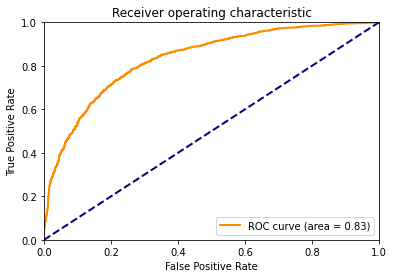

In [ ]:
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

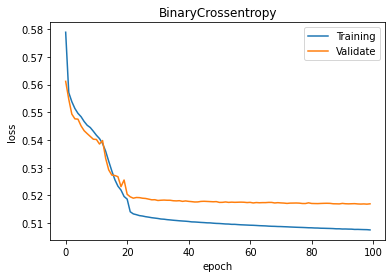

In [ ]:
#paint the loss and val_loss through the training
plt.plot(history.history['loss'],  label='Training')
plt.plot(history.history['val_loss'],  label='Validate')

plt.legend()
plt.title('BinaryCrossentropy')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()


In [ ]:
#save the model #save weight
lstm_model.save('./rnn_test.h5')

In [ ]:
#reload the model
from tensorflow.python.keras.models import load_model
lstm_model = load_model('/content/drive/My Drive/mimic-kdigo/MIMIC DATA 5.0/rnn_test.h5')
pre = lstm_model.predict(X_val)
print(pre)

[[[1.0479441e-02]
  [2.7455362e-03]
  [1.7610873e-03]
  [1.0676897e-03]
  [7.7253603e-04]
  [6.6130719e-04]]

 [[9.9406803e-01]
  [9.9681157e-01]
  [9.9542797e-01]
  [9.9341857e-01]
  [9.9269730e-01]
  [9.9293011e-01]]

 [[9.7328079e-01]
  [9.9138427e-01]
  [9.8995656e-01]
  [9.8784375e-01]
  [9.8753917e-01]
  [9.8848897e-01]]

 ...

 [[9.9473238e-01]
  [9.9772853e-01]
  [9.9672771e-01]
  [9.9543178e-01]
  [9.9503893e-01]
  [9.9519485e-01]]

 [[9.8979598e-01]
  [9.9586427e-01]
  [9.9464959e-01]
  [9.9283421e-01]
  [9.9218869e-01]
  [9.9233341e-01]]

 [[9.9748588e-01]
  [9.9845648e-01]
  [9.9640876e-01]
  [9.9484420e-01]
  [9.9337161e-01]
  [9.9265444e-01]]]


In [ ]:
print(X_train)
print(Y_train)
print(X_val)
print(Y_val)

[[[ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]
  [ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]
  [ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]
  [ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]
  [ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]
  [ 4.27045401e-01 -5.11691346e-01 -1.12715639e-03 ... -9.50248596e-02
   -1.00000000e+00 -1.00000000e+00]]

 [[-4.92774972e-01  7.98579496e-02 -1.20097049e-03 ... -1.29353073e-02
   -1.00000000e+00 -1.00000000e+00]
  [-4.92774972e-01  7.98579496e-02 -1.20097049e-03 ... -1.29353073e-02
   -1.00000000e+00 -1.00000000e+00]
  [-4.92774972e-01  7.98579496e-02 -1.20097049e-03 ... -1.29353073e-02
   -1.00000000e+00 -1.00000000e+00]
  [-4.92774972e-01  7.98579496e-02 

In [ ]:
# Model ACCURACY
y_predict = lstm_model.predict(X_val)
print(y_predict)
threshold = 0
x = []
y = []
for i in range(10):
    print("threshold = "+str(threshold))
    predict = []
    for k in y_predict:
        num = 0
        for j in k:
            num = num + j
        if(num/len(y_predict[0])>threshold):
            predict.append(1)
        else:
            predict.append(0)
    correct = 0
    
    for i in range(len(Y_val)):
        if(Y_val[i]==predict[i]):
            correct = correct+1

    print(predict)
    for i in Y_val:
        print(str(i)+', ', end='')
    print('')
    print("Model Accuracy : %f"%(correct/len(Y_val)))
    y.append(correct/len(Y_val))
    x.append(threshold)

    correct = 0
    predict_1 = 0
    for i in range(len(Y_val)):
        if(predict[i]==1):
            predict_1 = predict_1 + 1
        if(Y_val[i]==predict[i]):
            if(Y_val[i]==1):
                correct = correct+1
    if(predict_1==0):
        print("no predict 1 case")
    else:
        print("Model Specificity : %f"%(correct/predict_1))
    correct = 0
    predict_0 = 0
    for i in range(len(Y_val)):
        if(predict[i]==0):
            predict_0 = predict_0 + 1
        if(Y_val[i]==predict[i]):
            if(Y_val[i]==0):
                correct = correct+1
    if(predict_0==0):
        print("no predict 0 case")
    else:
        print("Model Sensitivity : %f"%(correct/predict_0))

    threshold = threshold + 0.1
print(x, y)
    

[[[0.1990371 ]
  [0.2405172 ]
  [0.19242644]
  [0.15522519]
  [0.14261249]
  [0.11964995]]

 [[0.75044775]
  [0.7932654 ]
  [0.7854248 ]
  [0.777749  ]
  [0.83276975]
  [0.76736885]]

 [[0.53741354]
  [0.54894173]
  [0.5416822 ]
  [0.38751614]
  [0.5113621 ]
  [0.76416963]]

 ...

 [[0.44781134]
  [0.5000117 ]
  [0.4931882 ]
  [0.5053292 ]
  [0.5464027 ]
  [0.65837   ]]

 [[0.86326575]
  [0.8358258 ]
  [0.82020235]
  [0.8212317 ]
  [0.80932164]
  [0.8877317 ]]

 [[0.54282933]
  [0.5551669 ]
  [0.51563287]
  [0.4991953 ]
  [0.12028332]
  [0.11007272]]]
threshold = 0
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import pickle
import tensorflow as tf
K = tf.keras.backend


from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import load_model


lstm_model = load_model('rnn_test.h5')
lstm_model.save_weights('rnn_test_weight.h5')
#test for django web
def buildTrain(train, pastDay, futureDay, hours):
    # 處理時序性Data
    X_train = []
    print(train.shape[0])
    train_data = np.array(train)
    #train_x_list=train_data.tolist()#list
    data = []
    index = 0
    for i in range(int(len(train_data)/int(hours/4))):
        small_data = []
        for j in range(int(hours/4)):
            small_data.append(train_data[index])
            index = index + 1
        data.append(small_data)
    return np.array(data)

def normalize(train):
    train_norm = train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
    return train_norm

File_df = pd.read_csv('NewExample.csv')
test_norm = normalize(File_df.drop(columns=['icustay_id']))
test_norm = test_norm.fillna(-1)
X_test = buildTrain(test_norm, 1, 1, 24)
Y_test = lstm_model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


FileNotFoundError: ignored

In [ ]:
print(Y_test)

[[[0.36336777]
  [0.295979  ]
  [0.21730782]
  [0.03868334]
  [0.08909453]
  [0.5859621 ]]

 [[0.41229746]
  [0.849035  ]
  [0.84496945]
  [0.86942255]
  [0.93098825]
  [0.99989927]]

 [[0.7783595 ]
  [0.7863642 ]
  [0.9352807 ]
  [0.9713869 ]
  [0.9662842 ]
  [0.9937967 ]]

 [[0.9858683 ]
  [0.9506562 ]
  [0.9623072 ]
  [0.962153  ]
  [0.9675406 ]
  [0.9910864 ]]

 [[0.7618321 ]
  [0.7970539 ]
  [0.7942362 ]
  [0.73363024]
  [0.5418315 ]
  [0.9342974 ]]

 [[0.90030354]
  [0.7663139 ]
  [0.5221715 ]
  [0.52407295]
  [0.5057946 ]
  [0.99682343]]

 [[0.34473994]
  [0.45771906]
  [0.60143507]
  [0.40684932]
  [0.8279917 ]
  [0.4687296 ]]

 [[0.484993  ]
  [0.5322514 ]
  [0.5931952 ]
  [0.6949497 ]
  [0.74009   ]
  [0.9927255 ]]

 [[0.57643217]
  [0.48174024]
  [0.39415824]
  [0.33069965]
  [0.40050364]
  [0.99923706]]

 [[0.21050924]
  [0.1679524 ]
  [0.23069273]
  [0.24895972]
  [0.27800888]
  [0.26642993]]

 [[0.35095817]
  [0.2810148 ]
  [0.5919341 ]
  [0.810376  ]
  [0.18838218]
  [0.

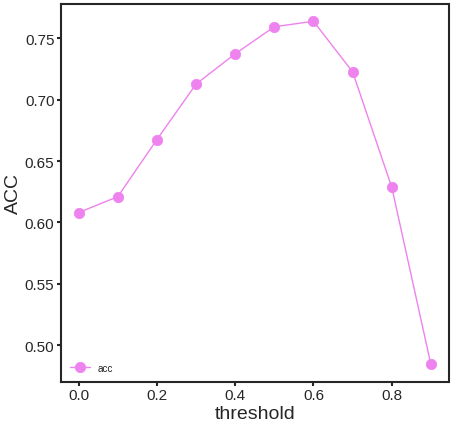

In [ ]:
import csv
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

font_size = 28
ticks_font_size = 22
plt.style.use('seaborn-ticks')
plt.figure(figsize=(10,10), dpi=50)#dpi越高 圖像品質越好 size有可能會變大


plt.xlabel('threshold', fontsize=font_size)
plt.xticks(fontsize=ticks_font_size)
plt.ylabel('ACC', fontsize=font_size)
plt.yticks(fontsize=ticks_font_size)

# [i/10 for i in range(1, 10)]  x軸要放的 type = list
# avg_list y軸要放的 type = list

avg_list = y
plt.plot([i/10 for i in range(0, 10)], avg_list, 'go-', markersize=15, color='violet', linewidth=2, label='acc')

plt.legend(loc='lower left', fontsize='x-large')
ax=plt.gca()
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)
ax.ticklabel_format(axis='y', scilimits=[-2, 2])
ax.yaxis.offsetText.set_fontsize(20)

In [ ]:
from tensorflow.python.keras.callbacks import LearningRateScheduler
from tensorflow.python.keras import backend as K
def scheduler(epoch):
    if epoch == 10:
        lr = 1e-4
        return lr
    else:
        lr = K.eval(lstm_model.optimizer.lr)
    return lr

change_lr = LearningRateScheduler(scheduler)
batch_size=128
epoch_num=1000
model_path = 'rnn_test.h5'

self_callback = [
    EarlyStopping(monitor="loss", patience=20, verbose=1, mode="auto", ),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint(model_path, verbose=0, save_best_only=False, save_weights_only=True),
    change_lr
]
lstm_model.compile(loss="BinaryCrossentropy", optimizer="AdaGrad",metrics=['binary_accuracy'])

history = lstm_model.fit(X_train, Y_train, batch_size=batch_size, epochs=epoch_num,
                                    validation_data=(X_val, Y_val), 
                                    callbacks=self_callback)


Epoch 1/1000
316/316 [==============================] - 2s 8ms/step - loss: 0.5123 - binary_accuracy: 0.7490 - val_loss: 0.5156 - val_binary_accuracy: 0.7463 - lr: 0.0010
Epoch 2/1000
142/316 [============>.................] - ETA: 1s - loss: 0.5055 - binary_accuracy: 0.7531

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-7cdacf11e80a>", line 26, in <module>
    callbacks=self_callback)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py", line 848, in fit
    tmp_logs = train_function(iterator)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 580, in __call__
    result = self._call(*args, **kwds)
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eager/def_function.py", line 611, in _call
    return self._stateless_fn(*args, **kwds)  # pylint: disable=not-callable
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/eage

KeyboardInterrupt: ignored